In [17]:
import itertools
import datetime
import dateutil.relativedelta

import time
import math

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot  as plt
matplotlib.rcParams['figure.figsize'] = [16, 16]


import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score

from keras import Sequential
from keras.layers import Dense, LSTM

matplotlib.rcParams['figure.figsize'] = [16, 10]



In [2]:
def _get_length_sequences_where(x):
    if len(x) == 0:
        return [0]
    else:
        res = [len(list(group)) for value, group in itertools.groupby(x) if value == 1]
        return res if len(res) > 0 else [0]

In [4]:
labels = pd.read_csv('../01_Data/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')
data_dict = pd.read_excel('../01_Data/data_dictionary.xlsx')
features = pd.read_csv('../03_Feature_Engineering/features.csv') 
wd_feas = pd.read_csv('../03_Feature_Engineering/windows_feas.csv') 

In [5]:
data_dict.head(1)

,Unnamed: 0,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,description,trip id,accuracy inferred by GPS in meters,GPS bearing,accelerometer reading in x axis (m/s2),accelerometer reading in y axis (m/s2),accelerometer reading in z axis (m/s2),gyroscope reading in x axis (rad/s),gyroscope reading in y axis (rad/s),gyroscope reading in z axis (rad/s),time of the record by number of seconds,speed measured by GPS in m/s


In [6]:
labels.label.value_counts(normalize = True)
labels = labels.groupby(['bookingID']).max().reset_index()
labels_0 = list(labels[labels.label==0].bookingID)
labels_1 = list(labels[labels.label==1].bookingID)

In [8]:
def features_creation(df):
    df['acceleration']  =  np.sqrt(df.acceleration_x*df.acceleration_x+\
                                 df.acceleration_y*df.acceleration_y+\
                                 df.acceleration_z*df.acceleration_z)
    df['gyro']  =  np.sqrt(df.gyro_x*df.gyro_x+\
                                 df.gyro_y*df.gyro_y+\
                                 df.gyro_z*df.gyro_z)
    df['stop'] =  np.where(df.Speed <2*10/36,1,0)
    df['signal_weak'] = np.where(df.Speed<0,1,0)
    #features['second_lag1']
    df['trip_start'] = df.bookingID.shift(+1)
    df['trip_start'] = np.where(df['bookingID'] ==df['trip_start'],0,1)
    
    df['trip_end'] = df.bookingID.shift(-1)
    df['trip_end'] = np.where(df['bookingID'] ==df['trip_end'],0,1)
    
    df['Speed_lag1'] = df.Speed.shift(+1)
    df['missing_ind'] = df.second.shift(+1)
    df['missing_ind'] = np.where((df['second'] - df['missing_ind'])<=2,0,1)
    
    df['acc_cal'] = df.Speed - df.Speed_lag1
    df['acc_cal'] = np.where((df['trip_start'] + df['missing_ind'] +df['signal_weak'])>=1,0,df['acc_cal'])
   
    
    return df

In [9]:
features = features_creation(features)

In [10]:
def _get_length_sequences_where(x):
    if len(x) == 0:
        return [0]
    else:
        res = [len(list(group)) for value, group in itertools.groupby(x) if value == 1]
        return res if len(res) > 0 else [0]

In [11]:
def events_calculation(df, thres={"b":-0.5,"b_harsh":-3,"b_harsh_avg":-2,
                                  "a":0.5,"a_harsh":3,"a_harsh_avg":2}):
    
    df['unrel'] = df['missing_ind_max'] + df['signal_weak_max'] 
    
    df['braking_event'] = np.where((df['acc_cal_mean']<thres['b']) | (df['acc_cal_min']<thres['b_harsh']),1,0)
    df['braking_harsh_event'] = np.where((df['acc_cal_mean']<thres['b_harsh_avg']) | (df['acc_cal_min']<thres['b_harsh']),1,0)
    df['braking_cali_event'] = np.where( df['unrel']==0,df['braking_event'],0)
    df['braking_harsh_cali_event'] = np.where(df['unrel']==0,df['braking_harsh_event'],0)
    
    
    df['acceleration_event'] = np.where((df['acc_cal_mean']>thres['a']) | (df['acc_cal_max']>thres['a_harsh']),1,0)
    df['acceleration_harsh_event'] = np.where((df['acc_cal_mean']>thres['a_harsh_avg']) | (df['acc_cal_max']>thres['a_harsh']),1,0)
    df['acceleration_cali_event'] = np.where( df['unrel']==0,df['acceleration_event'],0)
    df['acceleration_harsh_cali_event'] = np.where(df['unrel']==0,df['acceleration_harsh_event'],0)
    
    
    event_cols = ["bookingID","braking_event","braking_harsh_event","braking_cali_event","braking_harsh_cali_event",
            "acceleration_event","acceleration_harsh_event","acceleration_cali_event","acceleration_harsh_cali_event"]
    return df
events_calculation(wd_feas.head(10))
    

,bookingID,window,Accuracy_max,Accuracy_mean,Accuracy_min,Accuracy_std,Bearing_max,Bearing_mean,Bearing_min,Bearing_std,...,trip_end_sum,unrel,braking_event,braking_harsh_event,braking_cali_event,braking_harsh_cali_event,acceleration_event,acceleration_harsh_event,acceleration_cali_event,acceleration_harsh_cali_event
0,0,1,12.0,8.4,8.0,1.264911,143.298294,143.298294,143.298294,0.000000,...,0,1,1,1,0,0,0,0,0,0
1,0,2,8.0,8.0,8.0,0.000000,143.298294,143.298294,143.298294,0.000000,...,0,0,0,0,0,0,0,0,0,0
2,0,3,8.0,8.0,8.0,0.000000,143.298294,143.298294,143.298294,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,0,4,8.0,8.0,8.0,0.000000,143.298294,143.298294,143.298294,0.000000,...,0,0,0,0,0,0,0,0,0,0
4,0,5,8.0,8.0,8.0,0.000000,143.298294,143.298294,143.298294,0.000000,...,0,0,0,0,0,0,0,0,0,0
5,0,6,12.0,9.6,8.0,2.065591,143.298294,143.298294,143.298294,0.000000,...,0,0,0,0,0,0,0,0,0,0
6,0,7,12.0,11.6,8.0,1.264911,144.299423,143.798859,143.298294,0.527641,...,0,0,0,0,0,0,0,0,0,0
7,0,8,12.0,12.0,12.0,0.000000,144.299423,144.299423,144.299423,0.000000,...,0,0,0,0,0,0,0,0,0,0
8,0,9,12.0,12.0,12.0,0.000000,144.299423,144.299423,144.299423,0.000000,...,0,0,0,0,0,0,0,0,0,0
9,0,10,12.0,12.0,12.0,0.000000,144.299423,144.299423,144.299423,0.000000,...,0,0,0,0,0,0,0,0,0,0


In [12]:
event_info = events_calculation(wd_feas)
event_info.shape

(3231989, 45)

In [13]:
event_info.columns

Index(['bookingID', 'window', 'Accuracy_max', 'Accuracy_mean', 'Accuracy_min',
       'Accuracy_std', 'Bearing_max', 'Bearing_mean', 'Bearing_min',
       'Bearing_std', 'Speed_max', 'Speed_mean', 'Speed_min', 'Speed_std',
       'gyro_max', 'gyro_mean', 'gyro_min', 'gyro_std', 'acceleration_max',
       'acceleration_mean', 'acceleration_min', 'acceleration_std',
       'acc_cal_max', 'acc_cal_mean', 'acc_cal_min', 'acc_cal_std',
       'signal_weak_max', 'signal_weak_sum', 'stop_max', 'stop_sum',
       'trip_start_max', 'trip_start_sum', 'missing_ind_max',
       'missing_ind_sum', 'trip_end_max', 'trip_end_sum', 'unrel',
       'braking_event', 'braking_harsh_event', 'braking_cali_event',
       'braking_harsh_cali_event', 'acceleration_event',
       'acceleration_harsh_event', 'acceleration_cali_event',
       'acceleration_harsh_cali_event'],
      dtype='object')

In [14]:
def window_analysis_new(event, sample, sample_wd, window_size=10,
                        event_cols = ["breaking_cali_event","breaking_harsh_cali_event"],
                       colors = ['r','k'], wd_events=False, event_display=False):
    if (wd_events):
        event_cols+=['missing_ind_max','signal_weak_max',"stop_max"]
    colors+=['bo','ko','yo']
    ow = int(window_size/2)
    nps = len(sample_wd); 
    if event =="Speed":
        data = sample.Speed.values; lw=2
        x_points = range(0,len(data)) 
        y_points = data
        plt.plot(data,label="Speed")
        plt.plot(sample.acc_cal.values,label="Acceleration")
        plt.plot([0]*len(data))
    elif event == "Path":
        data = sample.Bearing.values; lw=4
        speed = sample.Speed.values
        x=0;y=0;x_points=[x];y_points=[y]
        for i in range(len(speed)):
            x+=speed[i] * math.sin(math.radians(data[i])); x_points.append(x)
            y+=speed[i] * math.cos(math.radians(data[i])); y_points.append(y)
        plt.plot(x_points,y_points,label="path")
        plt.plot(x_points[0], y_points[0], 'g^-',label="Start",markersize=12)
        plt.plot(x_points[-1], y_points[-1], 'r^-',label="End", markersize=12)
    else:
        pass
       
            
    no_events = len(event_cols)
    for j in range(no_events):
        plt.plot(x_points[0],y_points[0], colors[j], linewidth=0.5, label=event_cols[j])
        if (event_display):
            print (event_cols[j], np.sum(sample_wd[event_cols[j]].values))
        for i in range(0,nps):
        
            
            if sample_wd[event_cols[j]].values[i]:
                plt.plot(x_points[(i)*ow:(i+2)*ow],y_points[(i)*ow:(i+2)*ow], colors[j], linewidth=lw)
    event_cols=[]
    plt.legend()

In [20]:
def plot2(sample_id=0, feastures = features,event_feas=event_info, 
          data_points=0, start_point=0, subpart=False, wd_events=False, event_display=False):
    
  
    window_size=5
    if (subpart):
        sample = features[features.bookingID == sample_id][start_point:start_point+data_points]
        sample_event = event_feas[wd_feas.bookingID == sample_id][start_point:start_point+int(data_points/5)]
    else:
        sample = features[features.bookingID == sample_id]
        sample_event = event_feas[wd_feas.bookingID == sample_id]
    print ("Trip Duration", len(sample))

    acc = sample.acc_cal.values; bearing = sample.Bearing.values; speed = sample.Speed.values
    plt.subplot(311); window_analysis_new("Speed", sample, sample_event, 
                                          event_cols=["braking_cali_event","braking_harsh_cali_event"])
    plt.subplot(312); window_analysis_new("Path", sample, sample_event,   
                                          event_cols=["braking_cali_event","braking_harsh_cali_event"],
                                         wd_events=wd_events, event_display=event_display)

Trip Duration 150
braking_cali_event 11
braking_harsh_cali_event 11
missing_ind_max 0
signal_weak_max 0
stop_max 9


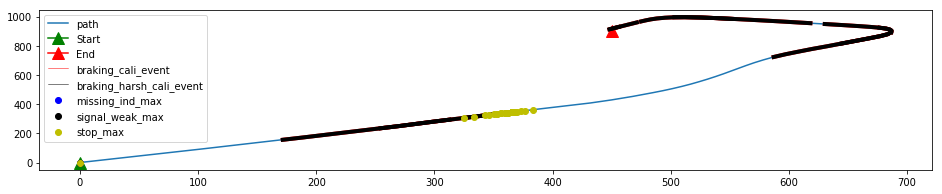

In [33]:
plot2(130, wd_events=True, event_display=True)